# BMI 203 HW2
## Parker Grosjean
------

In [177]:
# Importing all necessary dependencies

# Must first start pymol by typing  "pymol -R" in the terminal

# other packages
import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import networkx as gx
import scipy
# from pymol import cmd
cmd = xmlrpclib.ServerProxy('http://localhost:9123')
from IPython.display import Image
import xmlrpc.client as xmlrpclib
import time
# from openbabel import pybel

# my module
from clusters import algs

# **Part 1**
---------

Please see my [API documentation]() for an explanation of how to use my clustering algorithms. And please reference my [unit tests]() to show the efficacy of my algorithms.


# **Part 2**
---------

**Note**: For the sake of part 2 I will be running my analysis on a randomly sampled subset of 4000 data points out of of the total  for clustering

# Question 1

I chose to implement several metric functions in my API, which I implemented in my base class BaseMetric that both of my clustering classes inherit from. I included Tanimoto, Hamming, Euclidian (2-norm), Manhattan (1-norm), and Chebychev (inf-norm). Each of these metrics measure the distance between fingerprints differently. The Tanimoto distance makes the most sense however in the context of these hash fingerprints, because each bit represents a structual component of the molecule, so looking at the intersection over the union of the set is comparing how many structual similarities the molecules share with respect to the total number of strucutral components in each of the two molecules. But I wanted the API to be able to be as flexible as possible regarding metric functions. For the sake of the rest of Part 2 I will be using the Tanimoto metric function.

# Question 2

/Users/pgrosjean/opt/miniconda3/envs/algorithms/lib/python3.7/site-packages/umap/umap_.py:1763: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


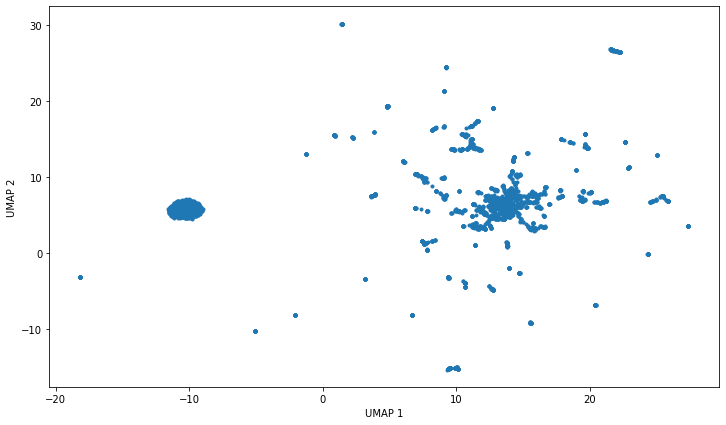

In [2]:
# Setting np.random seed for consistancy
np.random.seed(14)

# reading in ligand information csv files
ligand_list = algs.preprocess_data('ligand_information.csv')
# generating ligand fingerprint array
ligand_array = algs.generate_fingerprint_array(ligand_list)

# Randomly Sampling 4000 datapoints for use in clustering
num_pnts_sample = 4000
sampled_inds = np.random.choice(np.arange(ligand_array.shape[0]), num_pnts_sample)
ligand_arr_sub = ligand_array[sampled_inds, :] # Ligand Array Subset

# finding UMAP embedding (using jaccard metric function)
embedding = umap.UMAP(metric='jaccard').fit_transform(ligand_arr_sub)
# Generating dataframe for plotting
umap_df = pd.DataFrame({'UMAP 1': embedding[:, 0], 'UMAP 2': embedding[:, 1]})
# Plotting UMAP manifold
fig = plt.figure(figsize=(12,7))
plt.scatter(umap_df['UMAP 1'], umap_df['UMAP 2'], marker='.')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Question 3

To find the correct number of clusters, I am going to use a method used in spectral clustering. The reason I am doing this is because I tried calculating the silhoette scores for different numbers of clusters and found that the silhouette score almost always increases with more clusters until reaching almost the same number as clusters as ponts (see below on small test case). I hypothesize that this is because our feature space has 1024 dimensions and the data is likely just spread very sparsely throughout the space, which can be confirmed by the spread within the umap visualized in question 2. There are some larger clusters in the umap, but there is also a large spread of other molecules throughout the space. The way that the spectral clustering method works is by taking the affinity matrix as the weighted undirected adjacency matrix of a graph (see below for affinity matrix definition). Then by taking the laplacian of this graph one can generate a spectral (eigen) decomposition, from which one can find the maximum normalized eigengap (the greatest consecutive difference between two eigenvalues in the ordered array of all eigenvalues in the decomposition.) This works, becuase the normalized graph laplacian holds information about the connectivity of the matrix and more specifically infromation flow through the network. Finding the maximum eigengap describes the point at which changing the eigenfrequency within the graph leads to the most amount of information flow loss. Thus, this describes the best number of clusters at which information flow between points within the graph is maximized, where in this case one can think of information flow as the similarity between two fingerprints.

Converged after 1 iterations.
Converged after 2 iterations.
Converged after 4 iterations.
Converged after 5 iterations.


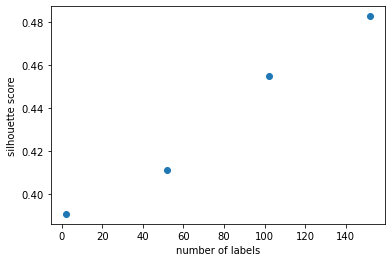

In [223]:
# Looking at silhouette scores for finding the correct number of clusters to use
s_scores = []
for k in range(2, 200, 50):
    cluster_p = algs.PartitionClustering(num_clusters=k, max_iter=100)
    clust_labels = cluster_p.cluster(ligand_arr_sub)
    cluster_quality = cluster_p.cluster_quality(ligand_arr_sub, clust_labels)
    s_scores.append(cluster_quality)
    
plt.scatter(range(2, 200, 50), s_scores)
plt.xlabel('number of labels')
plt.ylabel('silhouette score')
plt.show()

In [7]:
# Generating the distance matrix from a BaseMetric class instance
bm_instance = algs.BaseMetric(metric='tanimoto')
dist_arr = bm_instance.generate_dist_arr(ligand_arr_sub)

### Affinity Matrix

$$ A_{ij} = exp(\frac{-d(s_{i}, s_{j})}{\sigma^{2}})$$

Where sigma is a scaling factor defined per point as the distance to its kth closest neighbor

and d is the distance metric function

and s is the set of input instances

In [201]:
# generating the affinity matrix
k = 1
eps = 1e-7 # epsilon used for numerical stability
sigma_k = np.sort(dist_arr, axis=-1)[:, k] + eps
affinity_matrix = np.exp(-(dist_arr**2)/(sigma_k**2))

/Users/pgrosjean/opt/miniconda3/envs/algorithms/lib/python3.7/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


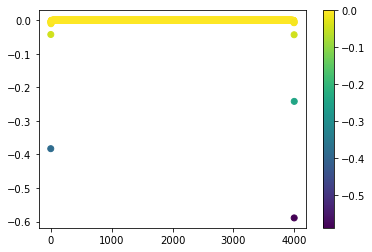

optimal number of clusters via spectral decomposition: 8


In [202]:
# Generating a networkx graph from the affinitity matrix
g = gx.convert_matrix.from_numpy_matrix(affinity_matrix)
# Calculating the normalized laplacian matrix of the graph
L = gx.linalg.laplacianmatrix.normalized_laplacian_matrix(g).todense()
# Calculating the eigenvalues of the normalized laplacian matrix of the graph
eig_vals = np.linalg.eigvals(L)
# Finding the maximum normalized eigen gap within the first 25% of eigenvalues
# I am choosing the first 25% of eigenvalues, because anything above this will
# start to get to the point where there are single values associated with each
# cluster, which just doesn't seem useful for the sake of clustering these 
# chemical fingerprints
mneg = np.argmax(np.abs(np.diff(np.sort(eig_vals)[::-1][5:int(0.25*affinity_matrix.shape[0])]))) + 1 # maxmimum normalized eigen gap
# Plotting the eigen gaps to show the maximum differnence
for_plot = np.diff(np.sort(eig_vals)[::-1])
color = for_plot.copy()
plt.scatter(np.arange(len(for_plot)), for_plot, c=for_plot)
plt.colorbar()
plt.show()
print(f'optimal number of clusters via spectral decomposition: {mneg}')

In [203]:
# Calculating 
cluster_p = algs.PartitionClustering(num_clusters=mneg, max_iter=500)
clust_labels_p = cluster_p.cluster(ligand_arr_sub)
cluster_quality_p = cluster_p.cluster_quality(ligand_arr_sub, clust_labels_p)
print(f'Silhouette Score: {cluster_quality_p}')

Converged after 2 iterations.
Silhouette Score: 0.36976632536253334


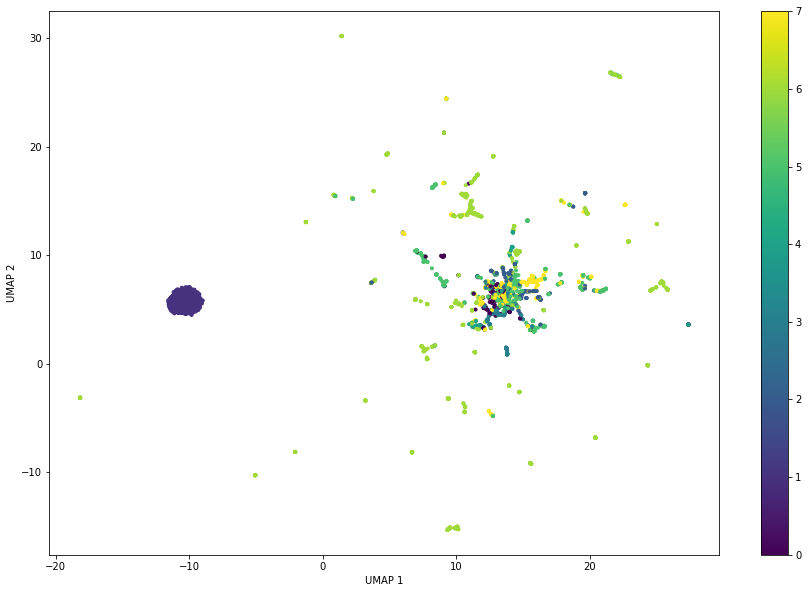

In [204]:
fig = plt.figure(figsize=(15,10))
plt.scatter(umap_df['UMAP 1'], umap_df['UMAP 2'], c=clust_labels_p, marker='.')
plt.colorbar()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Question 4

The Partitioning Algorithm that I chose to use was the K-Means algorithm. I chose this algorithm, because it is one of the most well known partition-based clustering algorithms and has been shown to work well in clustering based on similarity.

The K-means algorithm is sensitive to initial conditions and as such I implemented what is known as the kmeans++ algorithm for finding the initial cluster centers. The kmeans++ works by randomlhy choosing a point within the dataset and then randomly choosing the next cluster center with a weighted probability based on the distances. Thus, the initial cluster centers will be  spread throughout the dataset and won't end up being close to one another, which can cause poor clustering. In addition to these initial conditions it is also important to not that modifying the metric function also changes the outcome of the clustering. For example, when the Tanimoto distance or Hamming distance is used the cluster center cannot be taken as the average of all of the fingerprints, because the average fingerprints are almost never binary fingerprints, as is required by set based metric functions. Thus, when using these binary metric functions instead of assigning the average fingerprint as the new cluster center I assign the medoid of the cluster as the new cluster center.

I chose the number of clusters by finding the maximum normalized eigen gap of the affinitiy matrix which I described in Question 3. See this [medium article](https://towardsdatascience.com/spectral-graph-clustering-and-optimal-number-of-clusters-estimation-32704189afbe) that describes how the normalized eigen gap heuristic is calculated and why it can be used with partition-based clustering. I chose this becuase as can be seen by the graph in question 3, the silhouette score always increases with an increasing number of clusters (see my explanation in question 2 for my detailed thoughts).

# Question 5
Note for the sake of this clustering run I will be using the tanimoto metric function and the ward link, however my API has 6 different metric functions and 5 different linkages implemented. I chose to use the ward linkage as it is minimizing the variance after merging two clusters, which is ideal in the case of the sparse data in the large 1024 dimensional feature space.

In [ ]:
# Looking at silhouette scores for finding the correct number of clusters to use
s_scores = []
for k in range(2, 200, 50):
    cluster_h = algs.HierarchicalClustering(num_clusters=k, metric='tanimoto', linkage='ward')
    clust_labels = cluster_h.cluster(ligand_arr_sub)
    cluster_quality = cluster_h.cluster_quality(ligand_arr_sub, clust_labels)
    s_scores.append(cluster_quality)

# plotting the silhouette scores
plt.scatter(range(2, 200, 50), s_scores)
plt.xlabel('number of labels')
plt.ylabel('silhouette score')
plt.show()

In [206]:
# Running the clustering with the minimum normalized eigen gap number of clusters
cluster_h = algs.HierarchicalClustering(num_clusters=mneg, metric='tanimoto', linkage='ward')
clust_labels_h = cluster_h.cluster(ligand_arr_sub)
cluster_quality_h = cluster_h.cluster_quality(ligand_arr_sub, clust_labels_h)
print(f'Silhouette Score: {cluster_quality_h}')

Silhouette Score: 0.3410633411096149


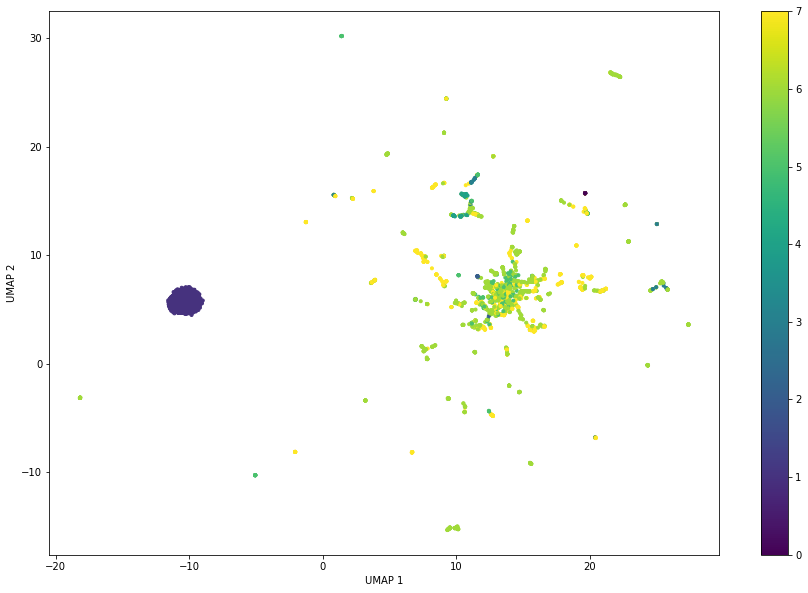

In [207]:
fig = plt.figure(figsize=(15,10))
plt.scatter(umap_df['UMAP 1'], umap_df['UMAP 2'], c=clust_labels_h, marker='.')
plt.colorbar()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Question 6
For the Heirarchical clustering algorithm I chose the aglomerative clustering algorithm. I chose this algorithm, because it is a well known clustering algorithm that starts with each infididual point as a cluster and builds up clusters by merging clusters together iteratively.

The aglomerative clustering algorithm is deterministic and therefore not affected by any intitial conditions. The intialization of the agglomerative clustering method is just to have each point in the dataset as its own cluster and then iteratively merge together the two closest clusters.

I again chose the number of clusters by finding the maximum normalized eigen gap of the affinitiy matrix which I described in Question 3. See this [medium article](https://towardsdatascience.com/spectral-graph-clustering-and-optimal-number-of-clusters-estimation-32704189afbe). I chose this becuase as can be seen by the graph in question 5, the silhouette score again always increases with an increasing number of clusters (see my explanation in question 2 for my detailed thoughts).

# Question 7

The partition clustering is shown to do marginally better than the partioining clustering according to the Silhouette Score quality metric. I chose the Silhouette Score as a quality metric, because it has an easy to interpret -1 to 1 value and takes into account the distance of each point to all points within its own cluster versus the second closest cluster. This is a good metric, because ideally you want the point to be very close to other points in its cluster but far from the points in the second closest cluster.

In [209]:
print(f'Partition Clustering Silhouette Score: {cluster_quality_p}')
print(f'Hierarchical Clustering Silhouette Score: {cluster_quality_h}')

Partition Clustering Silhouette Score: 0.36976632536253334
Hierarchical Clustering Silhouette Score: 0.3410633411096149


# Question 8

In [210]:
similarity_score = algs.cluster_similarity(ligand_arr_sub, clust_labels_h, clust_labels_p, index='jaccard')
print(f'Jaccard Index for Similarity b/w Clusters: {similarity_score}')

Jaccard Index for Similarity b/w Clusters: 0.47923600595682053


I chose to use the Jaccard index to investigate the similarity of the two cluster. The Jaccard index is the interesection over the union. So the outcome of this function shows that the two clusters are rather different from one another, which makes sense given the very different nature of the two clustering algorithms. This is also something that would likely change given different choices of hyperparameters like the linkage for Heirarchical clustering or metirc functions.

# Question 9

The clusters do not have dock scores that are very similar. For each cluster there is a spread of dock scores. This makes sense, becuase even molecules with the same 2d fingerprint can have drastically different dock scores based on the sampling function used in AutoDock Vina. For example, two different enatiomers and coformers can result in drastically different dock scores based on the 3d pose tested for the energy calculation. This can be observed in the kernel density estimation plots below for each of the clusters.

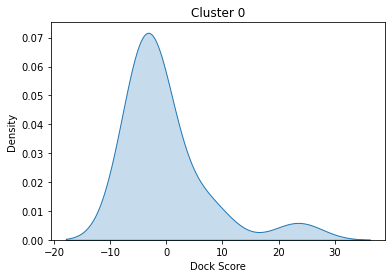

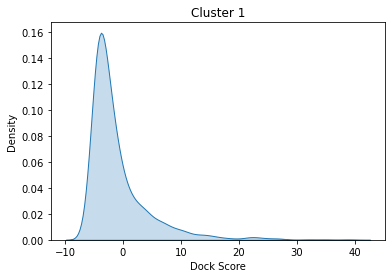

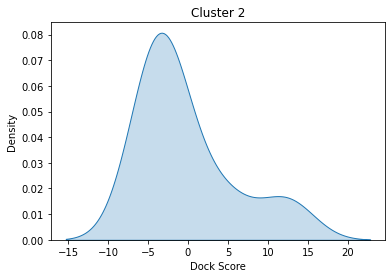

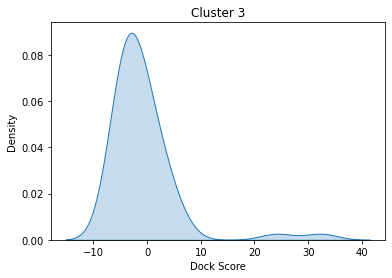

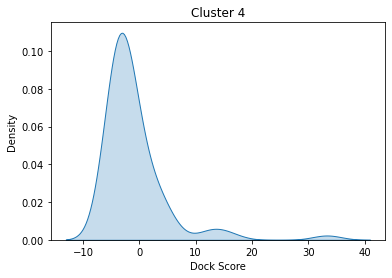

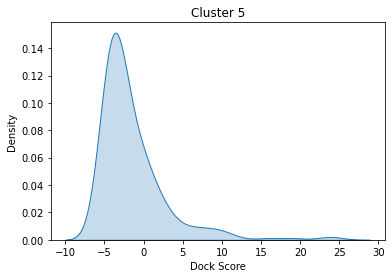

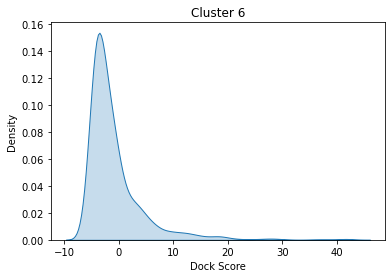

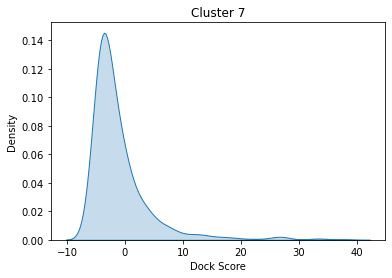

In [211]:
# visualizing distribution of Docking Scores per cluster
dock_scores = np.array([ligand.dock_score for ligand in ligand_list])
for cluster_num in np.unique(clust_labels_h):
    cluster_inds = np.arange(ligand_arr_sub.shape[0])[clust_labels_h == cluster_num]
    cluster_scores = dock_scores[cluster_inds]
    sns.kdeplot(cluster_scores, fill=True)
    plt.title(f'Cluster {int(cluster_num)}')
    plt.xlabel('Dock Score')
    plt.ylabel('Density')
    plt.show()

# Question 10

I guess my favorite cluster head is ligand_id 707, because it has a nice aromatic ring and delocalization of electrons is pretty neat. And the cluster heads all relatively structurally diverse, which would be expected given we are clustering on the structual fingerprints. I have visualized all top 5 cluster heads below.

In [212]:
# removing any preniously stored molecules
smiles = np.array([ligand.smiles for ligand in ligand_list])
ligand_ids = np.array([ligand.ligand_id for ligand in ligand_list])
if len(cmd.get_object_list('(all)')) > 0:
    for object_name in cmd.get_object_list('(all)'):
        cmd.delete(object_name)

objects in frame below: ['2019', 'receptor']


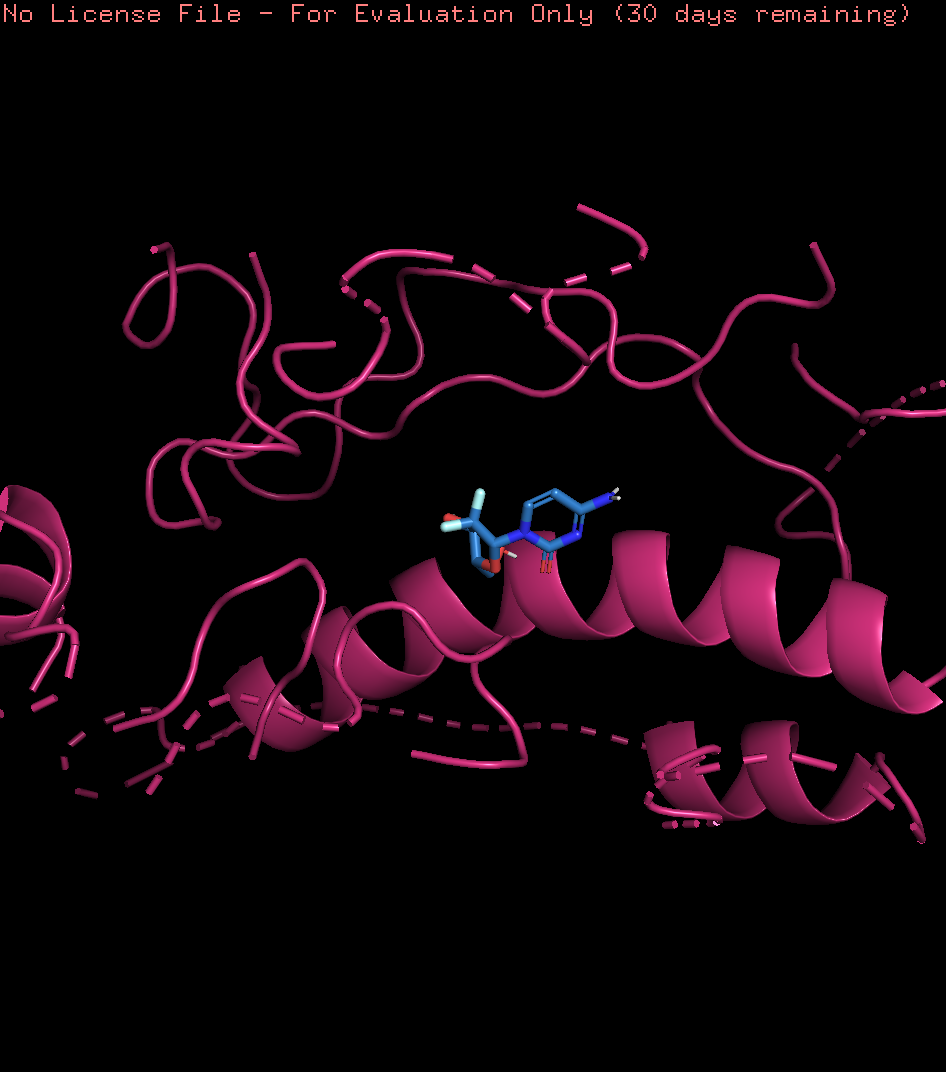

objects in frame below: ['1628', 'receptor']


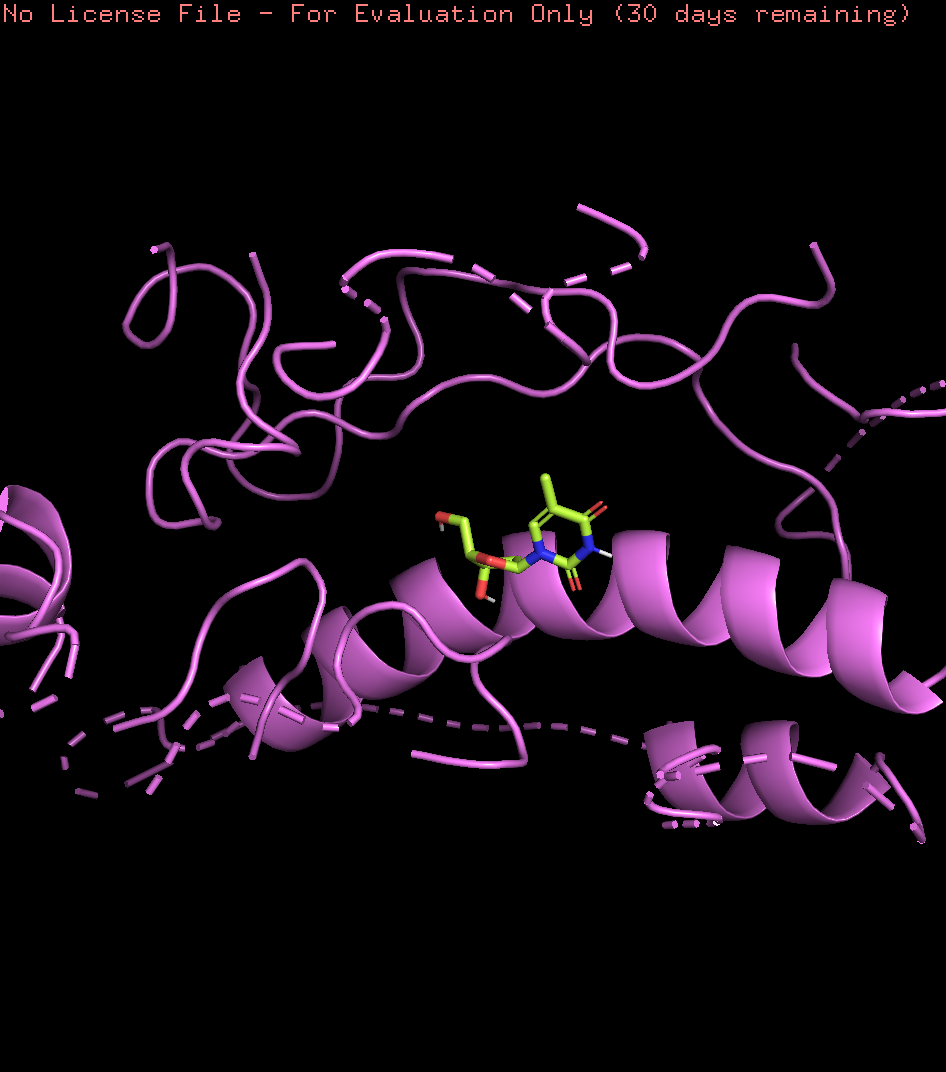

objects in frame below: ['878', 'receptor']


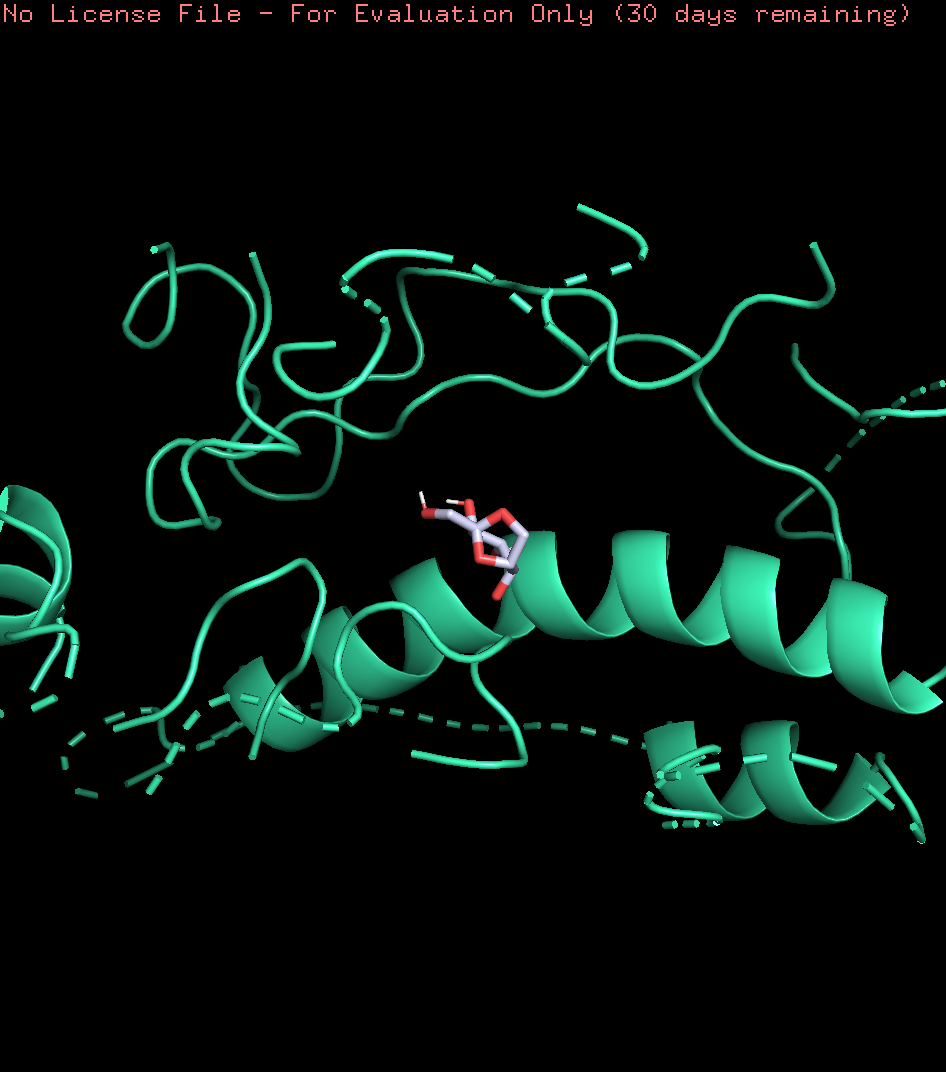

objects in frame below: ['747', 'receptor']


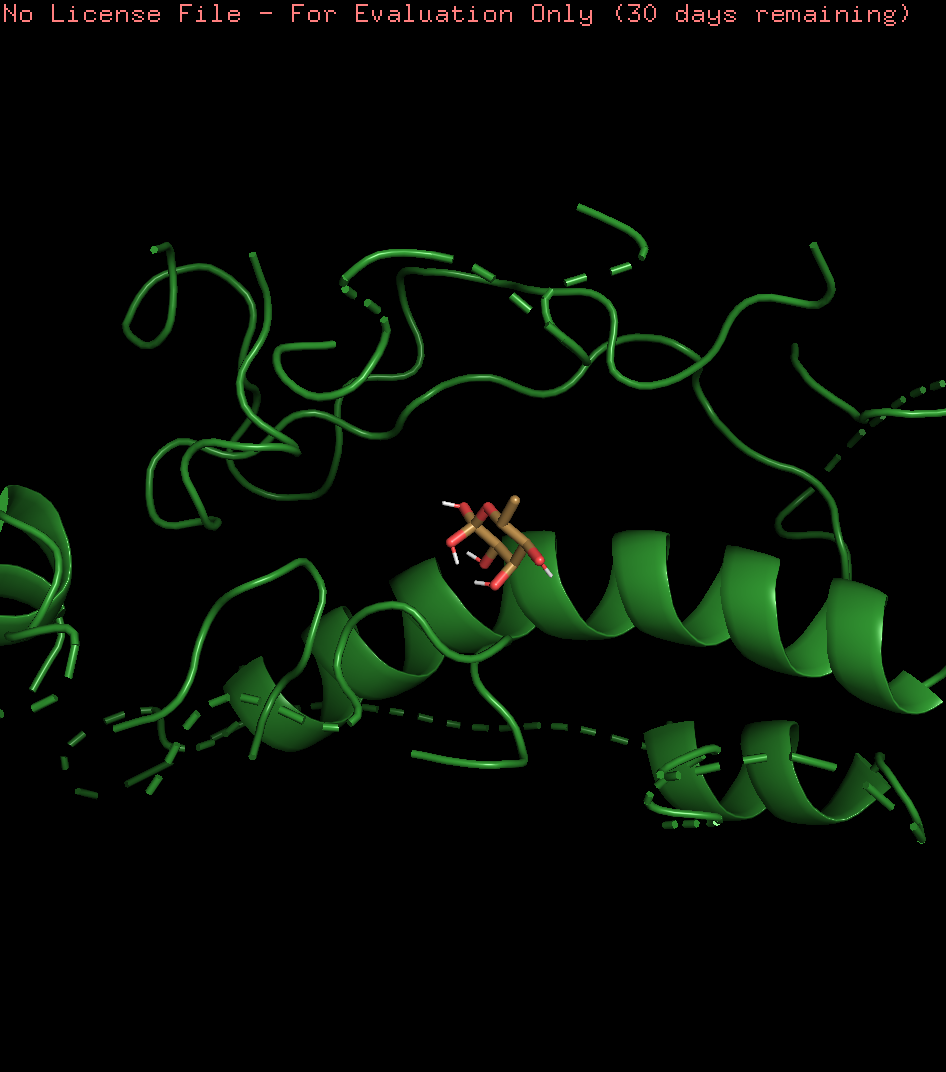

objects in frame below: ['707', 'receptor']


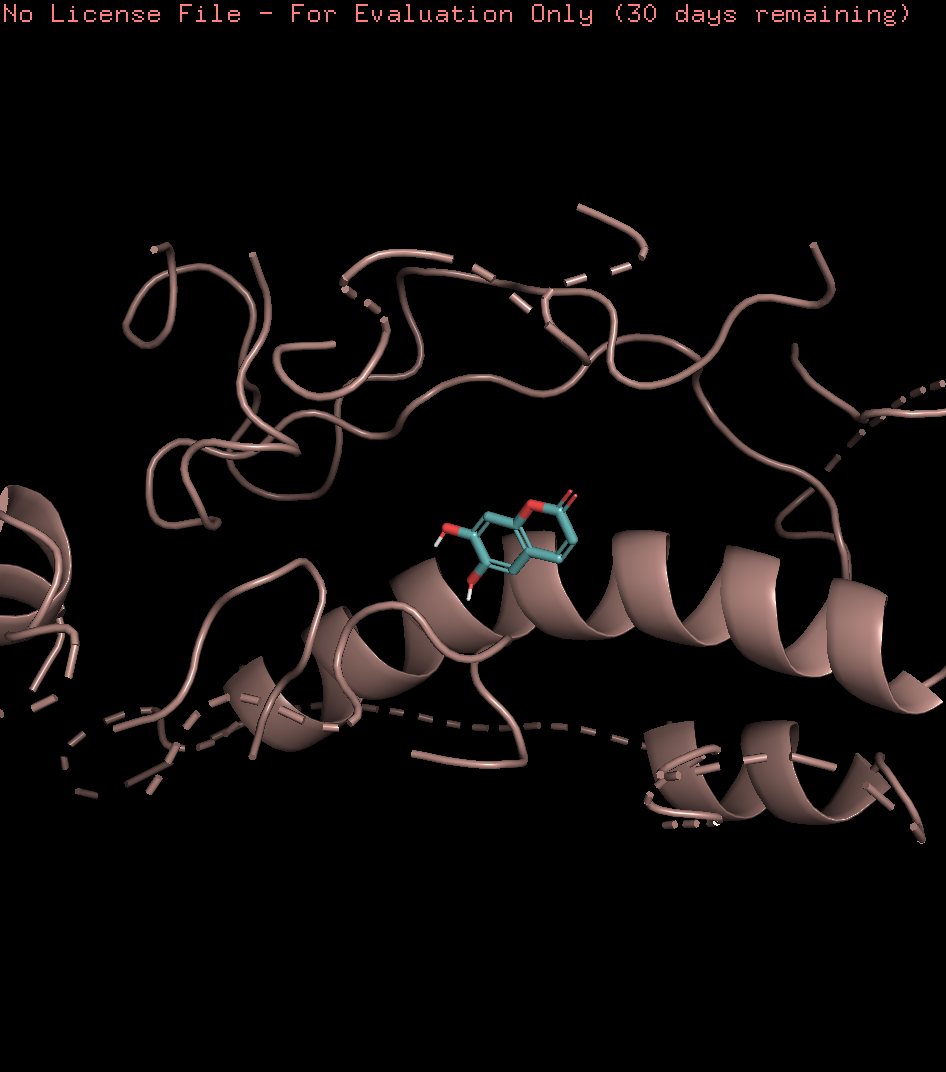

In [217]:
# Generating and observing all of the 3d Molecules

# finding top 5 cluster heads
cluster_heads = []

smiles = np.array([ligand.smiles for ligand in ligand_list])
ligand_ids = np.array([ligand.ligand_id for ligand in ligand_list])
for cluster_num in np.unique(clust_labels_h):
    cluster_inds = np.arange(ligand_arr_sub.shape[0])[clust_labels_h == cluster_num]
    cluster_scores = dock_scores[cluster_inds]
    min_energy_idx = np.argmin(cluster_scores)
    cluster_smiles = smiles[cluster_inds]
    cluster_ids = ligand_ids[cluster_inds]
    min_cluster_smiles = cluster_smiles[min_energy_idx]
    min_cluster_id = cluster_ids[min_energy_idx]
    cluster_heads.append((min_cluster_id, np.amin(cluster_scores)))

cluster_heads = sorted(cluster_heads, key = lambda x: x[1])
cluster_heads = cluster_heads[:5]
for min_cluster_id, _ in cluster_heads:
    filename = f'./data/{min_cluster_id}.sdf'
    cmd.load(filename)
    cmd.load(f'./data/receptor.pdb')
    cmd.orient(f'receptor')
    time.sleep(2)
    cmd.png(f'cluster_head_{int(cluster_num)}.png')
    print('objects in frame below:', cmd.get_object_list('(all)'))
    display(Image(filename=f'cluster_head_{int(cluster_num)}.png'))
    cmd.delete(f'{min_cluster_id}')
    cmd.delete(f'receptor')
    time.sleep(1)